# Определение рекламного текста с помощью LSTM-сети

## Импорты

In [8]:
!pip3 install gensim==3.8.1 emoji

     |████████████████████████████████| 24.2MB 125kB/s 
     |████████████████████████████████| 133kB 28.7MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [12]:
import re
import torch
import nltk
import json
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from collections import OrderedDict
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm as tqdm_notebook
from nltk.tokenize import WordPunctTokenizer

nltk.download("punkt")

punct = punctuation+'«»—…“”*№–'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
!unzip /content/drive/MyDrive/thesis_datasets/2ch_corpus.txt.zip

Archive:  /content/drive/MyDrive/thesis_datasets/2ch_corpus.txt.zip
  inflating: 2ch_corpus.txt          
  inflating: __MACOSX/._2ch_corpus.txt  


In [13]:
ad_data_path = "/content/drive/MyDrive/thesis_datasets/context_advertising_no_dups.csv"
non_ad_data_path = "2ch_corpus.txt"
toxic_data_path = "/content/drive/MyDrive/thesis_datasets/toxic_dataset.csv"
data_path = "/content/drive/MyDrive/thesis_datasets/ad_dataset.csv"

test_data_path = '/content/drive/MyDrive/thesis_datasets/ad_dataset_test.csv'
train_data_path = '/content/drive/MyDrive/thesis_datasets/ad_dataset_train.csv'
valid_data_path = '/content/drive/MyDrive/thesis_datasets/ad_dataset_valid.csv'

vector_model_path = "/content/drive/MyDrive/thesis_datasets/araneum_none_fasttextcbow_300_5_2018.model"

ad_model_best_state_path = "/content/drive/MyDrive/thesis_datasets/ad_model_best.pth"
ad_opt_best_state_path = "/content/drive/MyDrive/thesis_datasets/ad_opt_best.pth"
ad_model_last_state_path = "/content/drive/MyDrive/thesis_datasets/ad_model_last.pth"
ad_opt_last_state_path = "/content/drive/MyDrive/thesis_datasets/ad_opt_last.pth"

ad_vocab_path = '/content/drive/MyDrive/thesis_datasets/ad_vocab.json'

## Подготовка датасета

Так как в датасете рекламных текстов содержатся только рекламные тексты, необходимо добавить примерно такое же количество нерекламных текстов. В качестве нерекламных текстов выступают датасеты для функциональностей определения токсичности текста и определения наличия в тексте нецензурных слов.

In [11]:
# ad_data = pd.read_csv(ad_data_path)
# toxic_data = pd.read_csv(toxic_data_path)
# with open(non_ad_data_path, "r") as non_ad:
#     non_ad_data = non_ad.readlines()

In [8]:
# len(ad_data)

350007

In [9]:
# len(non_ad_data)

85903

In [12]:
# len(toxic_data)

262702

In [19]:
# ad_dataset = pd.DataFrame()
# ad_dataset["texts"] = ad_data.atext.values.tolist() + non_ad_data + toxic_data.texts.values.tolist()
# ad_dataset["ad"] = [1 for _ in range(len(ad_data))] + [0 for _ in range(len(non_ad_data) + len(toxic_data))]

In [20]:
# ad_dataset.head()

,texts,ad
0,Детский пейнтбол. Спортивный пейнтбол. Тактиче...,1
1,Успейте купить антигравитационный чехол для IP...,1
2,Антигравитационный чехол для телефона купить з...,1
3,Без справок! Получите до 3 000 грн. на карту п...,1
4,Акция! Получите Кредит Онлайн под 0%. Без Спра...,1


In [22]:
# len(ad_dataset)

698612

In [24]:
# ad_dataset = ad_dataset.sample(frac=1)
# ad_dataset.to_csv(data_path, index=False)

## Данные

In [10]:
data = pd.read_csv(data_path)

In [14]:
data.dropna(inplace=True)

In [26]:
# data.head()

,texts,ad
0,Asus vivobook x540sa за 17 990 руб. Доставка!,1
1,а мне лучше многолетники!\n,0
2,Швейные машины Зингер. Сравните цены всех инте...,1
3,Купить Levenhuk! Levenhuk Левенгук Ra R72 ED D...,1
4,а что означает это клеймо?\n,0


In [44]:
# len(data)

698611

Здесь нет проблемы несбалансированности классов, поэтому в дальнейшем в качестве метрики можно будет использовать f1 macro.

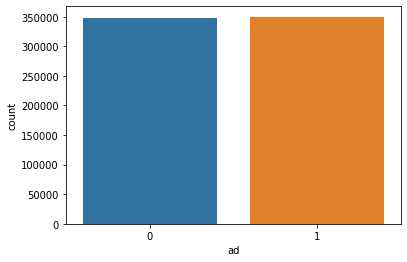

In [45]:
# sns.countplot(x='ad', data=data)

In [46]:
# X_train, X_test, y_train, y_test = train_test_split(data.texts, data.ad, test_size=0.02, random_state=42)

In [47]:
# len(X_train), len(X_test), len(y_train), len(y_test)

(684638, 13973, 684638, 13973)

In [48]:
# test_data = pd.DataFrame()
# test_data["texts"] = X_test
# test_data["ad"] = y_test
# test_data.to_csv(test_data_path, index=False)

In [49]:
# train_texts, valid_texts, train_targets, valid_targets = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [50]:
# len(train_texts), len(valid_texts)

(581942, 102696)

In [51]:
# train_data = pd.DataFrame()
# train_data["texts"] = train_texts
# train_data["ad"] = train_targets
# train_data.to_csv(train_data_path, index=False)

# valid_data = pd.DataFrame()
# valid_data["texts"] = valid_texts
# valid_data["ad"] = valid_targets
# valid_data.to_csv(valid_data_path, index=False)

In [6]:
train_data = pd.read_csv(train_data_path)
valid_data = pd.read_csv(valid_data_path)

train_texts = train_data["texts"]
train_targets = train_data["ad"]
valid_texts = valid_data["texts"] 
valid_targets = valid_data["ad"]

In [15]:
tokenizer = WordPunctTokenizer().tokenize

In [54]:
lengths = [len(tokenizer(x)) for x in data.texts]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


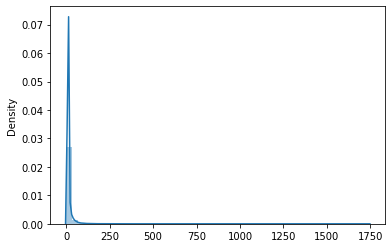

In [55]:
sns.distplot(lengths)

In [56]:
np.mean(lengths)

16.073368441092395

In [57]:
np.max(lengths)

1743

In [8]:
max_len = 30

## Эмбеддинги

In [16]:
fasttext = KeyedVectors.load(vector_model_path)

In [17]:
def get_vocab_embeddings(texts, tokenizer, vector_model=fasttext):
    vocab = {'<PAD>': 0}
    embeddings = [np.zeros(300)]
    
    for sentence in tqdm_notebook(texts):
        words = tokenizer(sentence)
        for word in words:
            if word not in vocab:
                vocab[word] = len(vocab)
                embeddings.append(vector_model[word])
    return vocab, embeddings

In [18]:
vocab, embeddings = get_vocab_embeddings(data.texts, tokenizer)

In [19]:
embeddings = torch.tensor(embeddings).float()

In [24]:
# json_dump = json.dumps(vocab)
# f = open(ad_vocab_path, "w")
# f.write(json_dump)
# f.close()  

## Обработчик данных

In [19]:
class BaddTextClassifierDataset(Dataset):
    
    def __init__(self, texts, targets, word_to_id, tokenizer, pad_index=0, max_len=30):
        super().__init__()
        
        self.texts = texts
        self.targets = targets
        self.vocab = word_to_id
        self.tokenizer = tokenizer
        self.pad_index = pad_index
        self.max_len = max_len
        
    def __len__(self):

        return len(self.texts)

    def tokenization(self, text):

        return self.tokenizer(text.lower())

    def get_text_indeces(self, tokenized_text):

        return [self.vocab[token] for token in tokenized_text if token in self.vocab]

    def padding(self, sequence):

        padds = [self.pad_index] * (self.max_len - len(sequence))
        sequence = sequence + padds
        return sequence
    
    def __getitem__(self, index):
       
        text = self.texts[index][:self.max_len]      
        tokenized_text = self.tokenization(text)
        indeces_of_text = self.get_text_indeces(tokenized_text)
        padded_text = self.padding(indeces_of_text)
        converted_text = torch.tensor(padded_text)

        target = self.targets[index]

        return converted_text, target

In [38]:
train_dataset = BaddTextClassifierDataset(train_texts, train_targets, vocab, tokenizer)
valid_dataset = BaddTextClassifierDataset(valid_texts, valid_targets, vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [121]:
for x, y in train_loader:
    break

In [122]:
x[0]

tensor([ 6231, 19566,  2710,    39, 20295,  1113,  5102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [123]:
y[0]

tensor(0)

## Модели

In [70]:
# device = torch.device('cpu')

In [21]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [40]:
class BaddAdLSTM(torch.nn.Module):
    
    def __init__(self, embeddings, vocab_size, num_classes, embedding_dim, hidden_dim, num_lstm_layers, linear_size, padding_idx):
        
        super().__init__()

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=padding_idx, freeze=False)

        self.lstm = torch.nn.LSTM(input_size=embedding_dim, 
                                  hidden_size=hidden_dim,
                                  num_layers=num_lstm_layers, 
                                  batch_first=True,
                                  bidirectional=False)

        self.relu = nn.ReLU()
        
        self.output_layer = torch.nn.Linear(in_features=hidden_dim,
                                            out_features=num_classes,
                                            bias=False)

        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.relu(x)
        x = self.output_layer(x)
        
        return x

In [41]:
vocab_size = len(vocab)
num_classes = 1
embedding_dim = 300
hidden_dim = 254
num_lstm_layers = 8
linear_size = 128
padding_idx = 0

In [42]:
ad_model = BaddAdLSTM(embeddings,
                                   vocab_size, 
                                   num_classes, 
                                   embedding_dim, 
                                   hidden_dim, 
                                   num_lstm_layers, 
                                   linear_size, 
                                   padding_idx)

ad_model.to(device)

BaddAdLSTM(
  (embedding_layer): Embedding(532251, 300, padding_idx=0)
  (lstm): LSTM(300, 254, num_layers=8, batch_first=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=254, out_features=1, bias=False)
)

## Обучение и валидация

In [46]:
def binarize(pred):
    pred = pred.cpu().detach().numpy()
    result = []
    for r in pred:
        if r <= 0.5:
            result.append(0.)
        else:
            result.append(1.)
    return result

In [26]:
def train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average, clip=3.0):

    train_losses = []
    f_scores_train = []

    model.train()
    
    train_progress_bar = tqdm_notebook(total=len(train_loader.dataset), desc=f'Epoch: {n_epoch + 1}, train', position=0, leave=True)
    

    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
            
        pred = model(x.detach())

        f_scores_train.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        
        loss = criterion(pred.cpu().squeeze(), y.cpu().float())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())

        train_progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))
        train_progress_bar.update(x.shape[0])

    train_progress_bar.close()

    return train_losses, f_scores_train

In [27]:
def validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average):

    valid_losses = []
    f_scores_valid = []

    model.eval()

    valid_progress_bar = tqdm_notebook(total=len(valid_loader.dataset), desc=f'Epoch: {n_epoch + 1}, validation', position=0, leave=True)

    for x, y in valid_loader:

        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():  
            pred = model(x.detach())

        f_scores_valid.append(f1_score(y.cpu().numpy(), binarize(pred), average=f_score_average))
        loss = criterion(pred.cpu().squeeze(), y.cpu().float())

        valid_losses.append(loss.item())

        valid_progress_bar.set_postfix(valid_loss = np.mean(valid_losses[-500:]))
        valid_progress_bar.update(x.shape[0])
    
    valid_progress_bar.close()

    return valid_losses, f_scores_valid

In [28]:
def save_model(model, optimizer, path_to_model_state, path_to_optimizer_state):
    torch.save(model.state_dict(), path_to_model_state)
    torch.save(optimizer.state_dict(), path_to_optimizer_state)

In [29]:
def train_and_validate(model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       best_model_state_path,
                       best_opt_state_path,
                       last_model_state_path,
                       last_opt_state_path):

    val_losses = []
    tr_losses = []
    mean_f_scores_train = []
    mean_f_scores_valid = []
    best_val_loss = 10.0

    for n_epoch in range(n_epochs):

        epoch_train_losses, f_scores_train = train_model(model, train_loader, optimizer, criterion, n_epoch, f_score_average)
        epoch_valid_losses, f_scores_valid = validate_model(model, valid_loader, optimizer, criterion, n_epoch, f_score_average)

        mean_epoch_val_loss = np.mean(epoch_valid_losses)
        mean_f_scores_train.append(np.mean(f_scores_train))
        mean_f_scores_valid.append(np.mean(f_scores_valid))
        val_losses.append(mean_epoch_val_loss)
        tr_losses.append(np.mean(epoch_train_losses))

        scheduler.step()

        if mean_epoch_val_loss < best_val_loss:
            best_val_loss = mean_epoch_val_loss
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, best_model_state_path, best_opt_state_path)
        else:
            print(f'Early stopping on epoch {n_epoch+1}')
            print(f"F-score on validation: {np.mean(f_scores_valid)}")
            save_model(model, optimizer, last_model_state_path, last_opt_state_path)
            break

    return val_losses, tr_losses, mean_f_scores_train, mean_f_scores_valid

In [41]:
n_epochs = 30
model_params =  [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', ad_model.named_parameters()))]
embedding_params = ad_model.embedding_layer.parameters()
f_score_average = "macro"
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.00001}])
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [42]:
%%time
valid_losses, train_losses, mean_f_scores_train, mean_f_scores_valid = train_and_validate(ad_model,
                       n_epochs,
                       train_loader,
                       valid_loader,
                       model_params,
                       embedding_params,
                       f_score_average,
                       criterion,
                       optimizer,
                       scheduler,
                       ad_model_best_state_path,
                       ad_opt_best_state_path,
                       ad_model_last_state_path,
                       ad_opt_last_state_path)


F-score on validation: 0.9816516935362652



F-score on validation: 0.984825026283842



F-score on validation: 0.9853377954233243



Early stopping on epoch 4
F-score on validation: 0.9856223876830704
CPU times: user 33min 59s, sys: 21min 33s, total: 55min 32s
Wall time: 57min 1s


## Графики

In [43]:
def show_f_scores_graph(f_scores, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(f_scores)
    plt.grid()
    if training:
      plt.title('F-scores on train')
    else:
      plt.title('F-scores on validation')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('f-score')

In [44]:
def show_losses_graph(losses, training=True, epoch=True):
    plt.figure(figsize=(7, 7))
    plt.plot(losses)
    plt.grid()
    if training:
      plt.title('Training process')
    else:
      plt.title('Validation process')
    if epoch:
      plt.xlabel('Epochs')
    else:
      plt.xlabel('Iterations')
    plt.ylabel('Loss function')

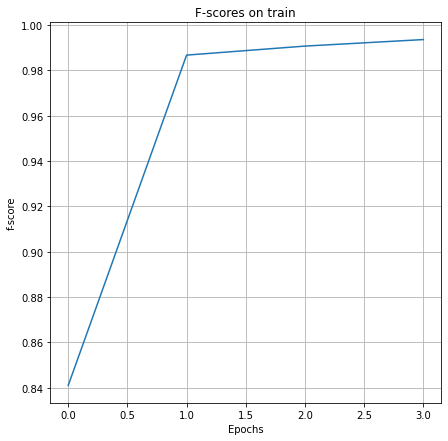

In [45]:
show_f_scores_graph(mean_f_scores_train, training=True)

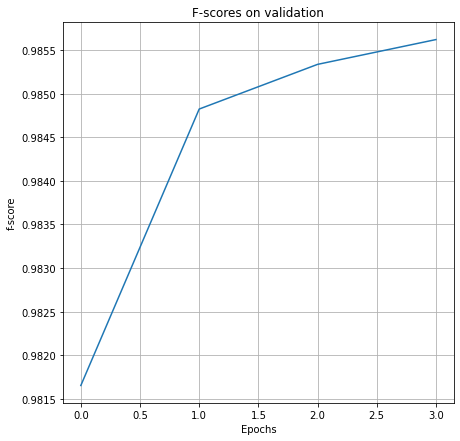

In [46]:
show_f_scores_graph(mean_f_scores_valid, training=False)

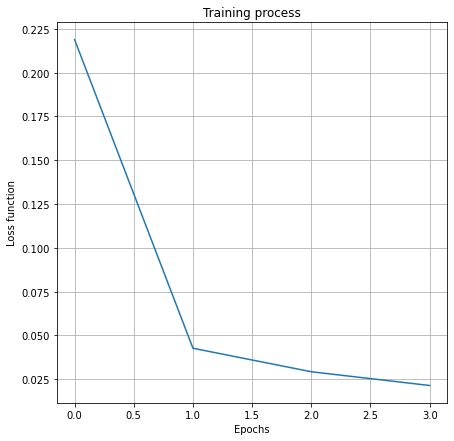

In [47]:
show_losses_graph(train_losses, training=True)

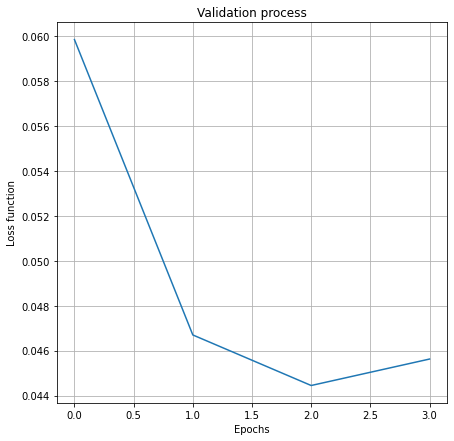

In [48]:
show_losses_graph(valid_losses, training=False)

## Оценка модели

In [39]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [26]:
f = open(ad_vocab_path, "r")
file = f.read()
f.close()  

vocab = json.loads(file)

In [28]:
tokenizer = WordPunctTokenizer().tokenize

In [29]:
test_data = pd.read_csv(test_data_path)

In [30]:
def load_model(path_to_model_state, path_to_optimizer_state):
    model_state = torch.load(path_to_model_state)
    optimizer_state = torch.load(path_to_optimizer_state)
    return model_state, optimizer_state

In [31]:
model, _ = load_model(ad_model_best_state_path, ad_opt_best_state_path)

In [43]:
ad_model.load_state_dict(model)

<All keys matched successfully>

In [36]:
def predict_text(text, model, tokenizer=tokenizer, vocab=vocab, max_len=30):
    tokenized_text = tokenizer(text.lower())
    ids = [vocab[token] for token in tokenized_text if token in vocab]
    padds = [0] * (max_len - len(ids))
    padded_ids = ids + padds
    tensor_ids = torch.tensor(padded_ids)
    tensor_ids = torch.unsqueeze(tensor_ids,0)
    
    with torch.no_grad():
      pred = model.forward(tensor_ids.to(device))
      pred = binarize(pred)
      return pred[0]

In [50]:
def make_preds(model, texts):
    model.eval()
    y_preds = []
    for text in texts:
        y_preds.append(predict_text(text, model))
    return y_preds

In [52]:
y_preds = make_preds(ad_model, test_data.texts)
y_trues = test_data.ad

In [59]:
def evaluate_on_texts(y_trues, y_preds, f_score_average = "macro"):
    
    print(f"F1 score: {f1_score(y_trues, y_preds, average=f_score_average)}")
    print(f"Accuracy: {accuracy_score(y_trues, y_preds)}")
    print(classification_report(y_trues, y_preds))

Результат с параметрами

| Параметр | Значение |
|---|---|
|embedding_dim | 300|
|hidden_dim | 254|
|num_lstm_layers | 8|
|linear_size | 128|

In [60]:
evaluate_on_texts(y_trues, y_preds)

F1 score: 0.992413619407786
Accuracy: 0.9924139411722608
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6951
           1       0.99      0.99      0.99      7022

    accuracy                           0.99     13973
   macro avg       0.99      0.99      0.99     13973
weighted avg       0.99      0.99      0.99     13973

